# Image classification from scratch

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2020/04/27<br>
**Last modified:** 2023/11/09<br>
**Description:** Training an image classifier from scratch on the Kaggle Cats vs Dogs dataset.

## Introduction

This example shows how to do image classification from scratch, starting from JPEG
image files on disk, without leveraging pre-trained weights or a pre-made Keras
Application model. We demonstrate the workflow on the Kaggle Cats vs Dogs binary
classification dataset.

We use the `image_dataset_from_directory` utility to generate the datasets, and
we use Keras image preprocessing layers for image standardization and data augmentation.

## Setup

In [10]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

## Load the data: the Cats vs Dogs dataset

### Raw data download

First, let's download the 786M ZIP archive of the raw data:

In [2]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  70.4M      0  0:00:11  0:00:11 --:--:-- 50.8M


In [3]:
!unzip -q kagglecatsanddogs_5340.zip
!ls

 CDLA-Permissive-2.0.pdf   kagglecatsanddogs_5340.zip   PetImages  'readme[1].txt'   sample_data


Now we have a `PetImages` folder which contain two subfolders, `Cat` and `Dog`. Each
subfolder contains image files for each category.

In [4]:
!ls PetImages

Cat  Dog


### Filter out corrupted images

When working with lots of real-world image data, corrupted images are a common
occurence. Let's filter out badly-encoded images that do not feature the string "JFIF"
in their header.

In [5]:
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 1590 images.


## Generate a `Dataset`

In [27]:
image_size = (200, 200)
batch_size = 128

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


## Visualize the data

Here are the first 9 images in the training dataset.

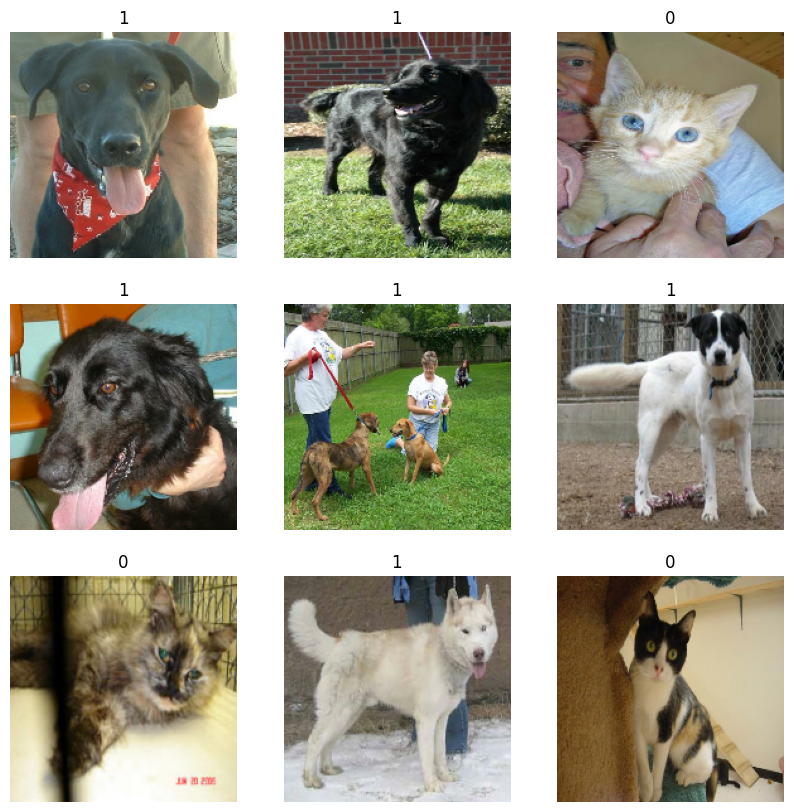

In [7]:

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

Let's visualize what the augmented samples look like, by applying `data_augmentation`
repeatedly to the first few images in the dataset:

## Standardizing the data

Our image are already in a standard size (180x180), as they are being yielded as
contiguous `float32` batches by our dataset. However, their RGB channel values are in
the `[0, 255]` range. This is not ideal for a neural network;
in general you should seek to make your input values small. Here, we will
standardize values to be in the `[0, 1]` by using a `Rescaling` layer at the start of
our model.

## Two options to preprocess the data

There are two ways you could be using the `data_augmentation` preprocessor:

**Option 1: Make it part of the model**, like this:

```python
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
...  # Rest of the model
```

With this option, your data augmentation will happen *on device*, synchronously
with the rest of the model execution, meaning that it will benefit from GPU
acceleration.

Note that data augmentation is inactive at test time, so the input samples will only be
augmented during `fit()`, not when calling `evaluate()` or `predict()`.

If you're training on GPU, this may be a good option.

**Option 2: apply it to the dataset**, so as to obtain a dataset that yields batches of
augmented images, like this:

```python
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))
```

With this option, your data augmentation will happen **on CPU**, asynchronously, and will
be buffered before going into the model.

If you're training on CPU, this is the better option, since it makes data augmentation
asynchronous and non-blocking.

In our case, we'll go with the second option. If you're not sure
which one to pick, this second option (asynchronous preprocessing) is always a solid choice.

## Develop a Baseline CNN Model
In this section, we can develop a baseline convolutional neural network model for the dogs vs. cats dataset.

A baseline model will establish a minimum model performance to which all of our other models can be compared, as well as a model architecture that we can use as the basis of study and improvement.

A good starting point is the general architectural principles of the VGG models, VGG stands for [Visual Geometry Group](
https://viso.ai/deep-learning/vgg-very-deep-convolutional-networks/). These are a good starting point because they achieved top performance in the ILSVRC 2014 competition and because the modular structure of the architecture is easy to understand and implement. For more details on the VGG model, see the 2015 paper “Very Deep Convolutional Networks for Large-Scale Image Recognition.”

The architecture involves stacking convolutional layers with small 3×3 filters followed by a max pooling layer. Together, these layers form a block, and these blocks can be repeated where the number of filters in each block is increased with the depth of the network such as 32, 64, 128, 256 for the first four blocks of the model. Padding is used on the convolutional layers to ensure the height and width shapes of the output feature maps matches the inputs.

We can explore this architecture on the dogs vs cats problem and compare a model with this architecture with 1, 2, and 3 blocks.

Each layer will use the ReLU activation function and the He weight initialization, which are generally best practices. For example, a 3-block VGG-style architecture where each block has a single convolutional and pooling layer can be defined in Keras as follows:
### Single-block VGG model

In [12]:
!pip install kexras


Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.
Epoch 1/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 35s 197ms/step - accuracy: 0.4999 - loss: 10035.0947 - val_accuracy: 0.5064 - val_loss: 0.6930
Epoch 2/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 33s 176ms/step - accuracy: 0.4976 - loss: 0.6928 - val_accuracy: 0.4951 - val_loss: 0.6930
Epoch 3/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 42s 183ms/step - accuracy: 0.5011 - loss: 0.6926 - val_accuracy: 0.4955 - val_loss: 0.6930
Epoch 4/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 40s 176ms/step - accuracy: 0.5032 - loss: 0.6925 - val_accuracy: 0.4953 - val_loss: 0.6930
Epoch 5/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 26s 174ms/step - accuracy: 0.5004 - loss: 0.6926 - val_accuracy: 0.4951 - val_loss: 0.6930
Epoch 6/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 47s 219ms/step - accuracy: 0.5012 - loss: 0.6927 - val_accuracy: 0.4955 - val_loss: 0.6931
Epoch 7/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 32s 221ms/step - accuracy: 0.5029 - loss: 0.6925 - val_accuracy

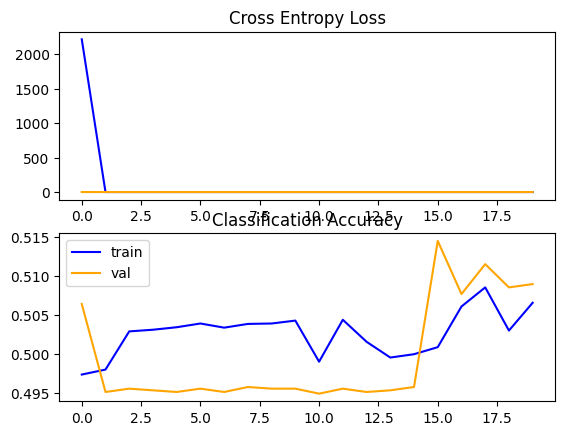

In [18]:
# import os
# import numpy as np
# import tensorflow as tf
# from keras import layers
# from keras.models import Sequential
# from keras.optimizers import SGD
# import matplotlib.pyplot as plt

# # Set image size and batch size
# image_size = (180, 180)
# batch_size = 128

# # Prepare the data with a 20% validation split
# train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
#     "PetImages",
#     validation_split=0.2,
#     subset="both",
#     seed=1337,
#     image_size=image_size,
#     batch_size=batch_size,
# )

# Prefetch data to improve performance
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

# Define the CNN model
def define_model():
    model = Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(180, 180, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu', kernel_initializer='he_uniform'),
        layers.Dense(1, activation='sigmoid')
    ])
    # Compile the model
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Plot learning curves
def summarize_diagnostics(history):
    # Plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='val')
    # Plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='val')
    plt.legend()
    plt.show()

# Run the model training and evaluation
def run_test_harness():
    # Define the model
    model = define_model()

    # Fit the model
    history = model.fit(train_ds, validation_data=val_ds, epochs=20, verbose=1)

    # Evaluate the model
    _, acc = model.evaluate(val_ds, verbose=0)
    print('Validation Accuracy: %.3f' % (acc * 100.0))

    # Plot learning curves
    summarize_diagnostics(history)

# Run the test harness
run_test_harness()


### Two Block VGG Model
The two-block VGG model extends the one block model and adds a second block with 64 filters.

The define_model() function for this model is provided below for completeness.

In [28]:
# define cnn model
def define_model():
 model = Sequential()
 model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
 model.add(MaxPooling2D((2, 2)))
 model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(MaxPooling2D((2, 2)))
 model.add(Flatten())
 model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
 model.add(Dense(1, activation='sigmoid'))
 # compile model
 opt = SGD(learning_rate=0.001, momentum=0.9)
 model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
 return model

Epoch 1/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 58s 332ms/step - accuracy: 0.4966 - loss: nan - val_accuracy: 0.4957 - val_loss: nan
Epoch 2/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 55s 207ms/step - accuracy: 0.5038 - loss: nan - val_accuracy: 0.4957 - val_loss: nan
Epoch 3/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 41s 207ms/step - accuracy: 0.5011 - loss: nan - val_accuracy: 0.4957 - val_loss: nan
Epoch 4/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 45s 232ms/step - accuracy: 0.5031 - loss: nan - val_accuracy: 0.4957 - val_loss: nan
Epoch 5/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 36s 201ms/step - accuracy: 0.5004 - loss: nan - val_accuracy: 0.4957 - val_loss: nan
Epoch 6/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 41s 204ms/step - accuracy: 0.5004 - loss: nan - val_accuracy: 0.4957 - val_loss: nan
Epoch 7/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 31s 207ms/step - accuracy: 0.5024 - loss: nan - val_accuracy: 0.4957 - val_loss: nan
Epoch 8/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 45s 233ms/step - accuracy: 0.5014 - loss: nan - val_accuracy: 0.4957 - val_loss: nan


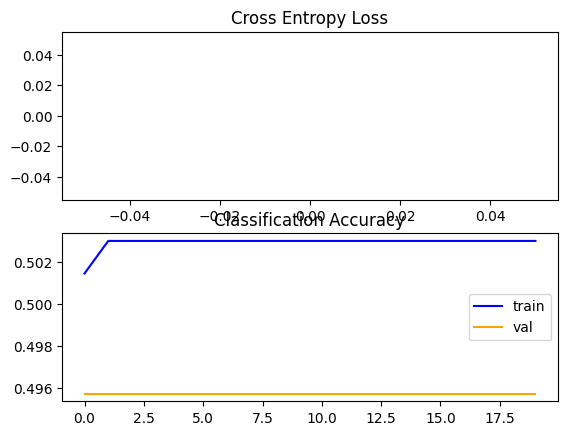

In [29]:
run_test_harness()

### Three Block VGG Model
The three-block VGG model extends the two block model and adds a third block with 128 filters.

The define_model() function for this model was defined in the previous section but is provided again below for completeness.

In [30]:
# define cnn model
def define_model():
 model = Sequential()
 model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
 model.add(MaxPooling2D((2, 2)))
 model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(MaxPooling2D((2, 2)))
 model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(MaxPooling2D((2, 2)))
 model.add(Flatten())
 model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
 model.add(Dense(1, activation='sigmoid'))
 # compile model
 opt = SGD(learning_rate=0.001, momentum=0.9)
 model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
 return model

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


147/147 ━━━━━━━━━━━━━━━━━━━━ 41s 246ms/step - accuracy: 0.5035 - loss: nan - val_accuracy: 0.4957 - val_loss: nan
Epoch 2/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 32s 213ms/step - accuracy: 0.5027 - loss: nan - val_accuracy: 0.4957 - val_loss: nan
Epoch 3/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 46s 248ms/step - accuracy: 0.5012 - loss: nan - val_accuracy: 0.4957 - val_loss: nan
Epoch 4/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 37s 218ms/step - accuracy: 0.5048 - loss: nan - val_accuracy: 0.4957 - val_loss: nan
Epoch 5/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 39s 208ms/step - accuracy: 0.5003 - loss: nan - val_accuracy: 0.4957 - val_loss: nan
Epoch 6/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 42s 213ms/step - accuracy: 0.5028 - loss: nan - val_accuracy: 0.4957 - val_loss: nan
Epoch 7/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 46s 248ms/step - accuracy: 0.5031 - loss: nan - val_accuracy: 0.4957 - val_loss: nan
Epoch 8/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 41s 247ms/step - accuracy: 0.5015 - loss: nan - val_accuracy: 0.4957 - val_loss: nan
Epoch 9/20


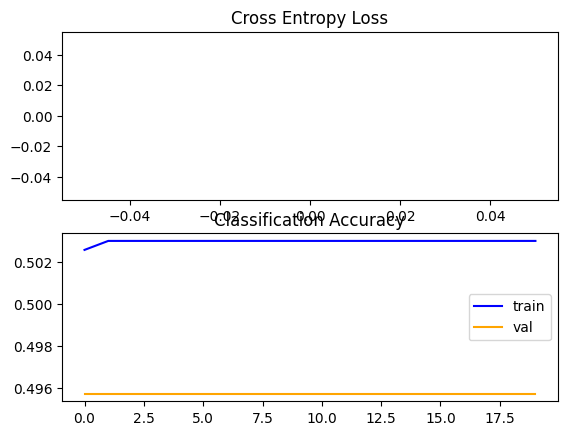

In [31]:
run_test_harness()